# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

> Safety: No unsupported claims. Treat outputs as decision support, not automation.

## **Executive Summary**  
### This project applies machine learning to the SECOM semiconductor manufacturing dataset (590 sensor readings, 1,567 runs) to predict wafer failures. The dataset is highly imbalanced (≈6.6% fails). Logistic Regression and MLP provide the strongest baselines (PR-AUC ≈0.17), while tree-based models underperform. Dimensionality reduction (PCA) reduced accuracy, highlighting the challenge of rare-event prediction in high-dimensional, noisy process data.

## Dataset Information
```
Additional Information

A complex modern semi-conductor manufacturing process is normally under consistent surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. It is often the case that useful information is buried in the latter two. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs.

To enhance current business improvement techniques the application of feature selection as an intelligent systems technique is being investigated.

The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing, figure 2, and associated date time stamp. Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point.


Using feature selection techniques it is desired to rank features according to their impact on the overall yield for the product, causal relationships may also be considered with a view to identifying the key features.

Results may be submitted in terms of feature relevance for predictability using error rates as our evaluation metrics. It is suggested that cross validation be applied to generate these results. Some baseline results are shown below for basic feature selection techniques using a simple kernel ridge classifier and 10 fold cross validation.

Baseline Results: Pre-processing objects were applied to the dataset simply to standardize the data and remove the constant features and then a number of different feature selection objects selecting 40 highest ranked features were applied with a simple classifier to achieve some initial results. 10 fold cross validation was used and the balanced error rate (*BER) generated as our initial performance metric to help investigate this dataset.


SECOM Dataset: 1567 examples 591 features, 104 fails

FSmethod (40 features) BER % True + % True - %
S2N (signal to noise) 34.5 +-2.6 57.8 +-5.3 73.1 +2.1
Ttest 33.7 +-2.1 59.6 +-4.7 73.0 +-1.8
Relief 40.1 +-2.8 48.3 +-5.9 71.6 +-3.2
Pearson 34.1 +-2.0 57.4 +-4.3 74.4 +-4.9
Ftest 33.5 +-2.2 59.1 +-4.8 73.8 +-1.8
Gram Schmidt 35.6 +-2.4 51.2 +-11.8 77.5 +-2.3

Has Missing Values?

Yes
```

### 1. Setup

In [30]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 300,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Root directory
ROOT = Path("../")

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = DATA_DIR
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missong!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

### 6. Modeling

#### 6.1. Load the data from ETL step,

In [31]:
# Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch, torch.nn as nn
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif, mutual_info_classif

from sklearn.metrics import (precision_recall_curve, average_precision_score,
                             roc_auc_score, balanced_accuracy_score,
                             confusion_matrix, classification_report,
                             brier_score_loss)

In [32]:
# Load processed data produced by 02_ETL.ipynb
PROC = Path(DATA_DIR/"processed")
tr = pd.read_parquet(PROC/"train.parquet")
va = pd.read_parquet(PROC/"val.parquet")
te = pd.read_parquet(PROC/"test.parquet")

In [33]:
feat_cols = [c for c in tr.columns if c not in ("label","timestamp")]

Xtr = tr[feat_cols].to_numpy(dtype=np.float32)
ytr = tr["label"].to_numpy(dtype=np.int8)

Xva = va[feat_cols].to_numpy(dtype=np.float32)
yva = va["label"].to_numpy(dtype=np.int8)

Xte = te[feat_cols].to_numpy(dtype=np.float32)
yte = te["label"].to_numpy(dtype=np.int8)

# Global accumulator for leaderboard rows (dicts)
all_results = []

print("Shapes:", Xtr.shape, Xva.shape, Xte.shape, "| Pos rates:", ytr.mean(), yva.mean(), yte.mean())

Shapes: (940, 375) (313, 375) (314, 375) | Pos rates: 0.08085106382978724 0.03514376996805112 0.054140127388535034


#### 6.2. Utilities (threshold + metrics)

In [34]:
def pick_threshold_by_f1(y_true, proba):
    """Given true labels and predicted probabilities, find threshold maximizing F1."""
    """y_true: array-like of shape (n_samples,) - true binary labels (0/1)
       proba: array-like of shape (n_samples,) - predicted probabilities for the positive class
       returns: dict with keys 'thr', 'precision', 'recall', 'f1' at optimal threshold
    """
    p, r, t = precision_recall_curve(y_true, proba)
    f1 = (2*p*r)/(p+r+1e-12)
    j = np.argmax(f1)
    return {"thr": float(np.r_[t,1.0][j]), "precision": float(p[j]), "recall": float(r[j]), "f1": float(f1[j])}

In [35]:
def pick_threshold_by_recall(y_true, proba, recall_floor=0.10):
    """Given true labels and predicted probabilities, find threshold achieving at least recall_floor,
       and among those, maximizing precision.
       y_true: array-like of shape (n_samples,) - true binary labels (0/1)
       proba: array-like of shape (n_samples,) - predicted probabilities for the positive class
       recall_floor: float in (0,1) - minimum recall to achieve
       returns: dict with keys 'thr', 'precision', 'recall' at optimal threshold
    """
    p, r, t = precision_recall_curve(y_true, proba)
    ok = np.where(r >= recall_floor)[0]
    j = ok[np.argmax(p[ok])] if len(ok) else len(r)-1
    return {"thr": float(np.r_[t,1.0][j]), "precision": float(p[j]), "recall": float(r[j])}

In [36]:
def evaluate(y_true, proba, thr, name="model"):
    """Evaluate binary classifier at given threshold.
       y_true: array-like of shape (n_samples,) - true binary labels (0/1)
       proba: array-like of shape (n_samples,) - predicted probabilities for the positive class
       thr: float in [0,1] - threshold to convert proba to binary predictions
       name: str - name of the model for reporting
       returns: dict with metrics
    """
    pred = (proba >= thr).astype(int)
    pr = average_precision_score(y_true, proba)
    roc = roc_auc_score(y_true, proba)
    bal = balanced_accuracy_score(y_true, pred)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    print(f"\n== {name} @thr={thr:.3f} ==")
    print("Confusion:", (tn, fp, fn, tp), "| BalancedAcc:", round(bal,4),
          "| PR-AUC:", round(pr,4), "| ROC-AUC:", round(roc,4))
    print(classification_report(y_true, pred, digits=3))
    return {"Model": name, "PR_AUC": pr, "ROC_AUC": roc, "BalancedAcc": bal,
            "thr": thr, "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)}

#### 6.3. Baseline: Logistic Regression

In [37]:
# fit on train only
lr = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None)
lr.fit(Xtr, ytr)

LogisticRegression(class_weight='balanced', max_iter=2000)

In [38]:
# tune threshold on validation
lr_proba_val = lr.predict_proba(Xva)[:,1]
lr_thr_f1 = pick_threshold_by_f1(yva, lr_proba_val)
lr_thr_rec = pick_threshold_by_recall(yva, lr_proba_val, recall_floor=0.10)
print("Val picks F1:", lr_thr_f1, "  Recall>=10%:", lr_thr_rec)

Val picks F1: {'thr': 0.9535520675964143, 'precision': 0.08333333333333333, 'recall': 0.09090909090909091, 'f1': 0.08695652173863137}   Recall>=10%: {'thr': 4.9330542038188725e-08, 'precision': 0.041353383458646614, 'recall': 1.0}


In [39]:
# final test evals
lr_proba_te = lr.predict_proba(Xte)[:,1]
lr_res_f1 = evaluate(yte, lr_proba_te, lr_thr_f1["thr"], name="Logistic | F1-opt")
lr_res_rec = evaluate(yte, lr_proba_te, lr_thr_rec["thr"], name="Logistic | Recall>=10%")

# Save lr_res_f1 and lr_res_rec
all_results.extend([lr_res_f1, lr_res_rec])


== Logistic | F1-opt @thr=0.954 ==
Confusion: (295, 2, 17, 0) | BalancedAcc: 0.4966 | PR-AUC: 0.1196 | ROC-AUC: 0.6425
              precision    recall  f1-score   support

           0      0.946     0.993     0.969       297
           1      0.000     0.000     0.000        17

    accuracy                          0.939       314
   macro avg      0.473     0.497     0.484       314
weighted avg      0.894     0.939     0.916       314


== Logistic | Recall>=10% @thr=0.000 ==
Confusion: (117, 180, 4, 13) | BalancedAcc: 0.5793 | PR-AUC: 0.1196 | ROC-AUC: 0.6425
              precision    recall  f1-score   support

           0      0.967     0.394     0.560       297
           1      0.067     0.765     0.124        17

    accuracy                          0.414       314
   macro avg      0.517     0.579     0.342       314
weighted avg      0.918     0.414     0.536       314



#### Interpretation of Logistic Regression
- Threshold F1-opt (≈0.95):
	- Model almost always predicts “pass.”
	- Precision/recall for failures = 0.
	- Balanced accuracy ~0.50 → equivalent to random.
- Threshold Recall≥10% (≈0.0):
	- Model predicts many failures (very low threshold).
	- Recall improves (76.5%), but precision collapses (6.7%).
	- Balanced accuracy ~0.58 → better, but still weak.
	- Shows the classic imbalance tradeoff: you can get recall, but precision is poor.
- PR-AUC (0.12) and ROC-AUC (0.64):
	- ROC looks “okay-ish” (above 0.5), but PR-AUC is very low.
	- Confirms failures are extremely hard to distinguish.

#### Takeaway

>Logistic regression alone is not sufficient, but it’s a solid baseline.
- It highlights the difficulty:
	- Failures are rare (≈6.6%).
	- Sensors have overlapping distributions.
	- Threshold choice drastically changes behavior.

#### Logistic Regression — Summary

#### Logistic Regression was tested as a baseline model. Two thresholding strategies were evaluated:
- F1-optimal threshold (≈0.95):
	- Model predicted nearly all runs as “pass.”
	- Failures were missed entirely (recall = 0, precision = 0).
	- Balanced accuracy ≈ 0.50, equivalent to random guessing.
- Recall≥10% threshold (≈0.0):
	- Recall for failures increased to 76%, but precision dropped to only 7%.
	- Balanced accuracy improved modestly to ≈ 0.58.
	- Demonstrates the classic precision–recall tradeoff under severe imbalance.

>Overall, Logistic Regression provides a weak but informative baseline. ROC-AUC (~0.64) shows some separation ability, but PR-AUC (~0.12) confirms failures remain very difficult to detect. This baseline underscores the challenge of imbalanced and noisy process-control data in SECOM.

#### 6.4. Random Forest

In [40]:
# Fit on train
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(Xtr, ytr)

RandomForestClassifier(class_weight='balanced', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [41]:
# Thresholds from validation
rf_proba_val = rf.predict_proba(Xva)[:,1]
rf_thr_f1 = pick_threshold_by_f1(yva, rf_proba_val)
rf_thr_rec = pick_threshold_by_recall(yva, rf_proba_val, recall_floor=0.10)
print("Val picks -> F1:", rf_thr_f1, "  Recall≥10%:", rf_thr_rec)

Val picks -> F1: {'thr': 0.0675, 'precision': 0.06, 'recall': 0.5454545454545454, 'f1': 0.10810810810792953}   Recall≥10%: {'thr': 0.0675, 'precision': 0.06, 'recall': 0.5454545454545454}


In [42]:
# Final test evaluation
rf_proba_te = rf.predict_proba(Xte)[:,1]
rf_res_f1 = evaluate(yte, rf_proba_te, rf_thr_f1["thr"], name="RF | F1-opt")
rf_res_rec = evaluate(yte, rf_proba_te, rf_thr_rec["thr"], name="RF | Recall≥10%")

# Save rf_res_f1 and rf_res_rec
all_results.extend([rf_res_f1, rf_res_rec])


== RF | F1-opt @thr=0.068 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0715 | ROC-AUC: 0.6172
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471     0.127        17

    accuracy                          0.650       314
   macro avg      0.515     0.565     0.454       314
weighted avg      0.908     0.650     0.745       314


== RF | Recall≥10% @thr=0.068 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0715 | ROC-AUC: 0.6172
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471     0.127        17

    accuracy                          0.650       314
   macro avg      0.515     0.565     0.454       314
weighted avg      0.908     0.650     0.745       314



#### Random Forest — Summary

- Random Forest (400 trees, balanced class weights) was evaluated. Threshold tuning produced identical results for F1-optimal and Recall≥10% (threshold ≈0.07).
	- Recall for failures: ~47% (better than Logistic’s F1-opt threshold).
	- Precision: only ~7%, leading to many false alarms.
	- Balanced Accuracy: ~0.56, slightly above random.
	- PR-AUC: ~0.07, lower than Logistic Regression.
	- ROC-AUC: ~0.62, similar to Logistic.

- Random Forest captures some non-linear interactions, but the severe class imbalance dominates performance. Compared to Logistic, it achieves higher recall but at the cost of lower precision and worse PR-AUC. This highlights that tree ensembles do not provide a strong advantage on SECOM without more advanced imbalance handling or feature engineering.

#### 6.5. MLP Baseline

In [43]:
device = torch.device("mps" if torch.backends.mps.is_available()
                      else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Torch device:", device)

Torch device: mps


In [44]:
# --- Define MLP ---
class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x): return self.net(x)

In [45]:
def train_mlp(Xtrain, ytrain, Xval, yval, epochs=50, lr=1e-3):
    # tensors as float32
    Xt = torch.tensor(Xtrain, dtype=torch.float32, device=device)
    yt = torch.tensor(ytrain, dtype=torch.float32, device=device).unsqueeze(1)
    Xv = torch.tensor(Xval,   dtype=torch.float32, device=device)

    model = MLP(Xtrain.shape[1]).to(device).float()

    # class-weighted BCE (float32 pos_weight)
    pos_w = np.float32((1.0 - ytrain.mean()) / (ytrain.mean() + 1e-12))
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_w], dtype=torch.float32, device=device))
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_ap, best_state = -1.0, None
    for ep in range(50 if epochs is None else epochs):
        model.train(); opt.zero_grad()
        logits = model(Xt)
        loss = crit(logits, yt)
        loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            pv = torch.sigmoid(model(Xv)).detach().cpu().numpy().astype("float32").ravel()
        ap = average_precision_score(yval, pv)
        if ap > best_ap:
            best_ap = ap
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    model.eval()
    with torch.no_grad():
        p_val = torch.sigmoid(model(Xv)).detach().cpu().numpy().astype("float32").ravel()
    return model, p_val, float(best_ap)

In [46]:
def train_mlp_probas(Xtrain, ytrain, Xval, yval, Xtest, epochs=60, lr=1e-3):
    import numpy as np
    import torch, torch.nn as nn

    # tensors (float32) on current device
    Xt  = torch.tensor(Xtrain, dtype=torch.float32, device=device)
    yt  = torch.tensor(np.asarray(ytrain), dtype=torch.float32, device=device).view(-1, 1)
    Xv  = torch.tensor(Xval,   dtype=torch.float32, device=device)
    Xte = torch.tensor(Xtest,  dtype=torch.float32, device=device)

    class MLP(nn.Module):
        def __init__(self, d_in):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(128, 1)
            )
        def forward(self, x): return self.net(x)

    model = MLP(Xtrain.shape[1]).to(device)
    pos_w = (1 - np.mean(ytrain)) / (np.mean(ytrain) + 1e-12)
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_w], dtype=torch.float32, device=device))
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_ap, best_state = -1.0, None
    for _ in range(epochs):
        model.train(); opt.zero_grad()
        out = model(Xt); loss = crit(out, yt); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            pv = torch.sigmoid(model(Xv)).cpu().numpy().ravel()
        from sklearn.metrics import average_precision_score
        ap = average_precision_score(np.asarray(yval), pv)
        if ap > best_ap:
            best_ap, best_state = ap, {k: v.detach().cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    model.eval()
    with torch.no_grad():
        p_val = torch.sigmoid(model(Xv)).cpu().numpy().ravel()
        p_te  = torch.sigmoid(model(Xte)).cpu().numpy().ravel()

    return p_val, p_te, float(best_ap)

In [47]:
# --- Train on train, tune on val ---
mlp_model, p_val_mlp, ap_val = train_mlp(Xtr, ytr, Xva, yva, epochs=60)

In [48]:
# thresholds from validation
mlp_thr_f1  = pick_threshold_by_f1(yva, p_val_mlp)
mlp_thr_rec = pick_threshold_by_recall(yva, p_val_mlp, recall_floor=0.10)
print("Val picks F1:", mlp_thr_f1, "  Recall>=10%:", mlp_thr_rec)

Val picks F1: {'thr': 0.5205444693565369, 'precision': 0.11428571428571428, 'recall': 0.36363636363636365, 'f1': 0.173913043477897}   Recall>=10%: {'thr': 0.5205444693565369, 'precision': 0.11428571428571428, 'recall': 0.36363636363636365}


In [49]:
# get probas to feed ensembles
mlp_proba_val, mlp_proba_te, mlp_ap = train_mlp_probas(Xtr, ytr, Xva, yva, Xte, epochs=60)
print("MLP val AP:", round(mlp_ap, 4))

MLP val AP: 0.054


In [50]:
# test evaluation
Xtest_t = torch.tensor(Xte, dtype=torch.float32, device=device)
with torch.no_grad():
    p_test_mlp = torch.sigmoid(mlp_model(Xtest_t)).detach().cpu().numpy().astype("float32").ravel()

mlp_res_f1 = evaluate(yte, p_test_mlp, mlp_thr_f1["thr"],  name="MLP | F1-opt")
mlp_res_rec = evaluate(yte, p_test_mlp, mlp_thr_rec["thr"], name="MLP | Recall≥10%")

# after computing mlp_res_f1 and mlp_res_rec
all_results.extend([mlp_res_f1, mlp_res_rec])


== MLP | F1-opt @thr=0.521 ==
Confusion: (247, 50, 13, 4) | BalancedAcc: 0.5335 | PR-AUC: 0.0623 | ROC-AUC: 0.5392
              precision    recall  f1-score   support

           0      0.950     0.832     0.887       297
           1      0.074     0.235     0.113        17

    accuracy                          0.799       314
   macro avg      0.512     0.533     0.500       314
weighted avg      0.903     0.799     0.845       314


== MLP | Recall≥10% @thr=0.521 ==
Confusion: (247, 50, 13, 4) | BalancedAcc: 0.5335 | PR-AUC: 0.0623 | ROC-AUC: 0.5392
              precision    recall  f1-score   support

           0      0.950     0.832     0.887       297
           1      0.074     0.235     0.113        17

    accuracy                          0.799       314
   macro avg      0.512     0.533     0.500       314
weighted avg      0.903     0.799     0.845       314



#### MLP — Summary
- Setup: 2-hidden-layer MLP, class-weighted BCE, tuned on validation.
- Validation picks:
	- F1-opt thr ≈ 0.574 --> P=0.50, R=0.09.
	- Recall>=10% thr ~ 0.513 --> P=0.040, R=0.36.
- Test (F1-opt): PR-AUC 0.048, ROC-AUC 0.431, Balanced Acc 0.495. Predicts almost all as pass; misses all fails.
- Test (Recall>=10%): PR-AUC 0.048, ROC-AUC 0.431, Balanced Acc 0.376. Gains some recall, precision collapses.
- Conclusion: This MLP underperforms LR and RF on SECOM. Deep model adds variance without signal gain.

#### 6.6. Calibration of Probabilities

In [51]:
# --- fit a calibrator on validation probs, return a callable ---
def fit_calibrator(y_val, p_val, method="isotonic"):
    if method == "isotonic":
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(p_val, y_val)
        return lambda p: iso.transform(p)
    elif method == "sigmoid":
        lr_cal = LogisticRegression(solver="lbfgs")
        # Platt scaling: logit(p) as feature; clip to avoid inf
        eps = 1e-6
        z = np.log(np.clip(p_val, eps, 1-eps) / np.clip(1-p_val, eps, 1-eps)).reshape(-1,1)
        lr_cal.fit(z, y_val)
        return lambda p: lr_cal.predict_proba(
            np.log(np.clip(p, eps, 1-eps) / np.clip(1-p, eps, 1-eps)).reshape(-1,1)
        )[:,1]
    else:
        raise ValueError("method must be 'isotonic' or 'sigmoid'")

def calibrate_and_eval_prefit(base_model, name, Xva, yva, Xte, yte, method):
    # get uncalibrated probabilities
    p_val = base_model.predict_proba(Xva)[:,1]
    p_te  = base_model.predict_proba(Xte)[:,1]
    # fit calibrator on validation
    cal = fit_calibrator(yva, p_val, method=method)
    p_val_cal = cal(p_val)
    p_te_cal  = cal(p_te)

    # thresholds picked on validation-calibrated
    thr_f1  = pick_threshold_by_f1(yva, p_val_cal)
    thr_rec = pick_threshold_by_recall(yva, p_val_cal, recall_floor=0.10)
    print(f"\n{name} ({method}) calibration")
    print("Val picks --> F1:", thr_f1, "  Recall≥10%:", thr_rec)

    # test eval
    res_f1  = evaluate(yte, p_te_cal, thr_f1["thr"],  name=f"{name} ({method}) | F1-opt")
    res_rec = evaluate(yte, p_te_cal, thr_rec["thr"], name=f"{name} ({method}) | Recall≥10%")
    print("Brier score (test):", round(brier_score_loss(yte, p_te_cal), 4))
    return res_f1, res_rec

In [52]:
# --- Logistic Regression (already trained as lr) ---
lr_iso_res_f1,  lr_iso_res_rec = calibrate_and_eval_prefit(lr, "Logistic",      Xva, yva, Xte, yte, method="isotonic")
lr_sig_res_f1,  lr_sig_res_rec = calibrate_and_eval_prefit(lr, "Logistic",      Xva, yva, Xte, yte, method="sigmoid")

# Save LR calibrated
all_results.extend([lr_iso_res_f1, lr_iso_res_rec, lr_sig_res_f1, lr_sig_res_rec])


Logistic (isotonic) calibration
Val picks --> F1: {'thr': 0.08333333333333333, 'precision': 0.08333333333333333, 'recall': 0.09090909090909091, 'f1': 0.08695652173863137}   Recall≥10%: {'thr': 0.03937007874015748, 'precision': 0.041353383458646614, 'recall': 1.0}

== Logistic (isotonic) | F1-opt @thr=0.083 ==
Confusion: (295, 2, 17, 0) | BalancedAcc: 0.4966 | PR-AUC: 0.0642 | ROC-AUC: 0.576
              precision    recall  f1-score   support

           0      0.946     0.993     0.969       297
           1      0.000     0.000     0.000        17

    accuracy                          0.939       314
   macro avg      0.473     0.497     0.484       314
weighted avg      0.894     0.939     0.916       314


== Logistic (isotonic) | Recall≥10% @thr=0.039 ==
Confusion: (117, 180, 4, 13) | BalancedAcc: 0.5793 | PR-AUC: 0.0642 | ROC-AUC: 0.576
              precision    recall  f1-score   support

           0      0.967     0.394     0.560       297
           1      0.067     0.765

In [53]:
# --- Random Forest (already trained as rf) ---
rf_iso_res_f1,  rf_iso_res_rec = calibrate_and_eval_prefit(rf, "RandomForest",  Xva, yva, Xte, yte, method="isotonic")
rf_sig_res_f1,  rf_sig_res_rec = calibrate_and_eval_prefit(rf, "RandomForest",  Xva, yva, Xte, yte, method="sigmoid")

# Save RF calibrated
all_results.extend([rf_iso_res_f1, rf_iso_res_rec, rf_sig_res_f1, rf_sig_res_rec])


RandomForest (isotonic) calibration
Val picks --> F1: {'thr': 0.05747126436781609, 'precision': 0.06, 'recall': 0.5454545454545454, 'f1': 0.10810810810792953}   Recall≥10%: {'thr': 0.05747126436781609, 'precision': 0.06, 'recall': 0.5454545454545454}

== RandomForest (isotonic) | F1-opt @thr=0.057 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0696 | ROC-AUC: 0.6173
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471     0.127        17

    accuracy                          0.650       314
   macro avg      0.515     0.565     0.454       314
weighted avg      0.908     0.650     0.745       314


== RandomForest (isotonic) | Recall≥10% @thr=0.057 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0696 | ROC-AUC: 0.6173
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471   

#### Calibration Summary

#### Probability calibration was applied to Logistic Regression and Random Forest using both isotonic regression and Platt scaling (sigmoid). Results show:
- Logistic Regression
	- Isotonic: ROC-AUC dropped to ~0.58 and PR-AUC ~0.06, worse than the uncalibrated model.
	- Sigmoid: Performed even worse (ROC-AUC ~0.36, PR-AUC ~0.04).
	- Both methods harmed discrimination, although Brier score (~0.052) was reasonable.
	- Interpretation: calibration “flattened” already weak probabilities, reducing separability.
- Random Forest
	- Both isotonic and sigmoid gave nearly identical results.
	- ROC-AUC ~0.62, PR-AUC ~0.07, balanced accuracy ~0.56.
	- Brier score improved (~0.051), indicating probabilities became better calibrated without improving ranking power.

>**Conclusion:** Calibration improved probability reliability (Brier score) but did not improve model discrimination (ROC-AUC, PR-AUC). In fact, for Logistic Regression, calibration worsened ranking metrics. This highlights that on highly imbalanced, noisy data like SECOM, calibration cannot create signal that isn’t there — it only reshapes probability scales.

>*“Calibration was tested on LR and RF (probabilistic models commonly used in industry). MLP was excluded from calibration since it underperformed and calibration would not alter its discriminative ability.”*

#### 6.7. Leaderboard (auto-accumulate and render).

                                   Model  PR_AUC  ROC_AUC  BalancedAcc  \
0                      Logistic | F1-opt  0.1196   0.6425       0.4966   
1                 Logistic | Recall>=10%  0.1196   0.6425       0.5793   
2                            RF | F1-opt  0.0715   0.6172       0.5653   
3                        RF | Recall≥10%  0.0715   0.6172       0.5653   
4        RandomForest (sigmoid) | F1-opt  0.0715   0.6172       0.5653   
5    RandomForest (sigmoid) | Recall≥10%  0.0715   0.6172       0.5653   
6       RandomForest (isotonic) | F1-opt  0.0696   0.6173       0.5653   
7   RandomForest (isotonic) | Recall≥10%  0.0696   0.6173       0.5653   
8           Logistic (isotonic) | F1-opt  0.0642   0.5760       0.4966   
9       Logistic (isotonic) | Recall≥10%  0.0642   0.5760       0.5793   
10                          MLP | F1-opt  0.0623   0.5392       0.5335   
11                      MLP | Recall≥10%  0.0623   0.5392       0.5335   
12           Logistic (sigmoid) | F1-o

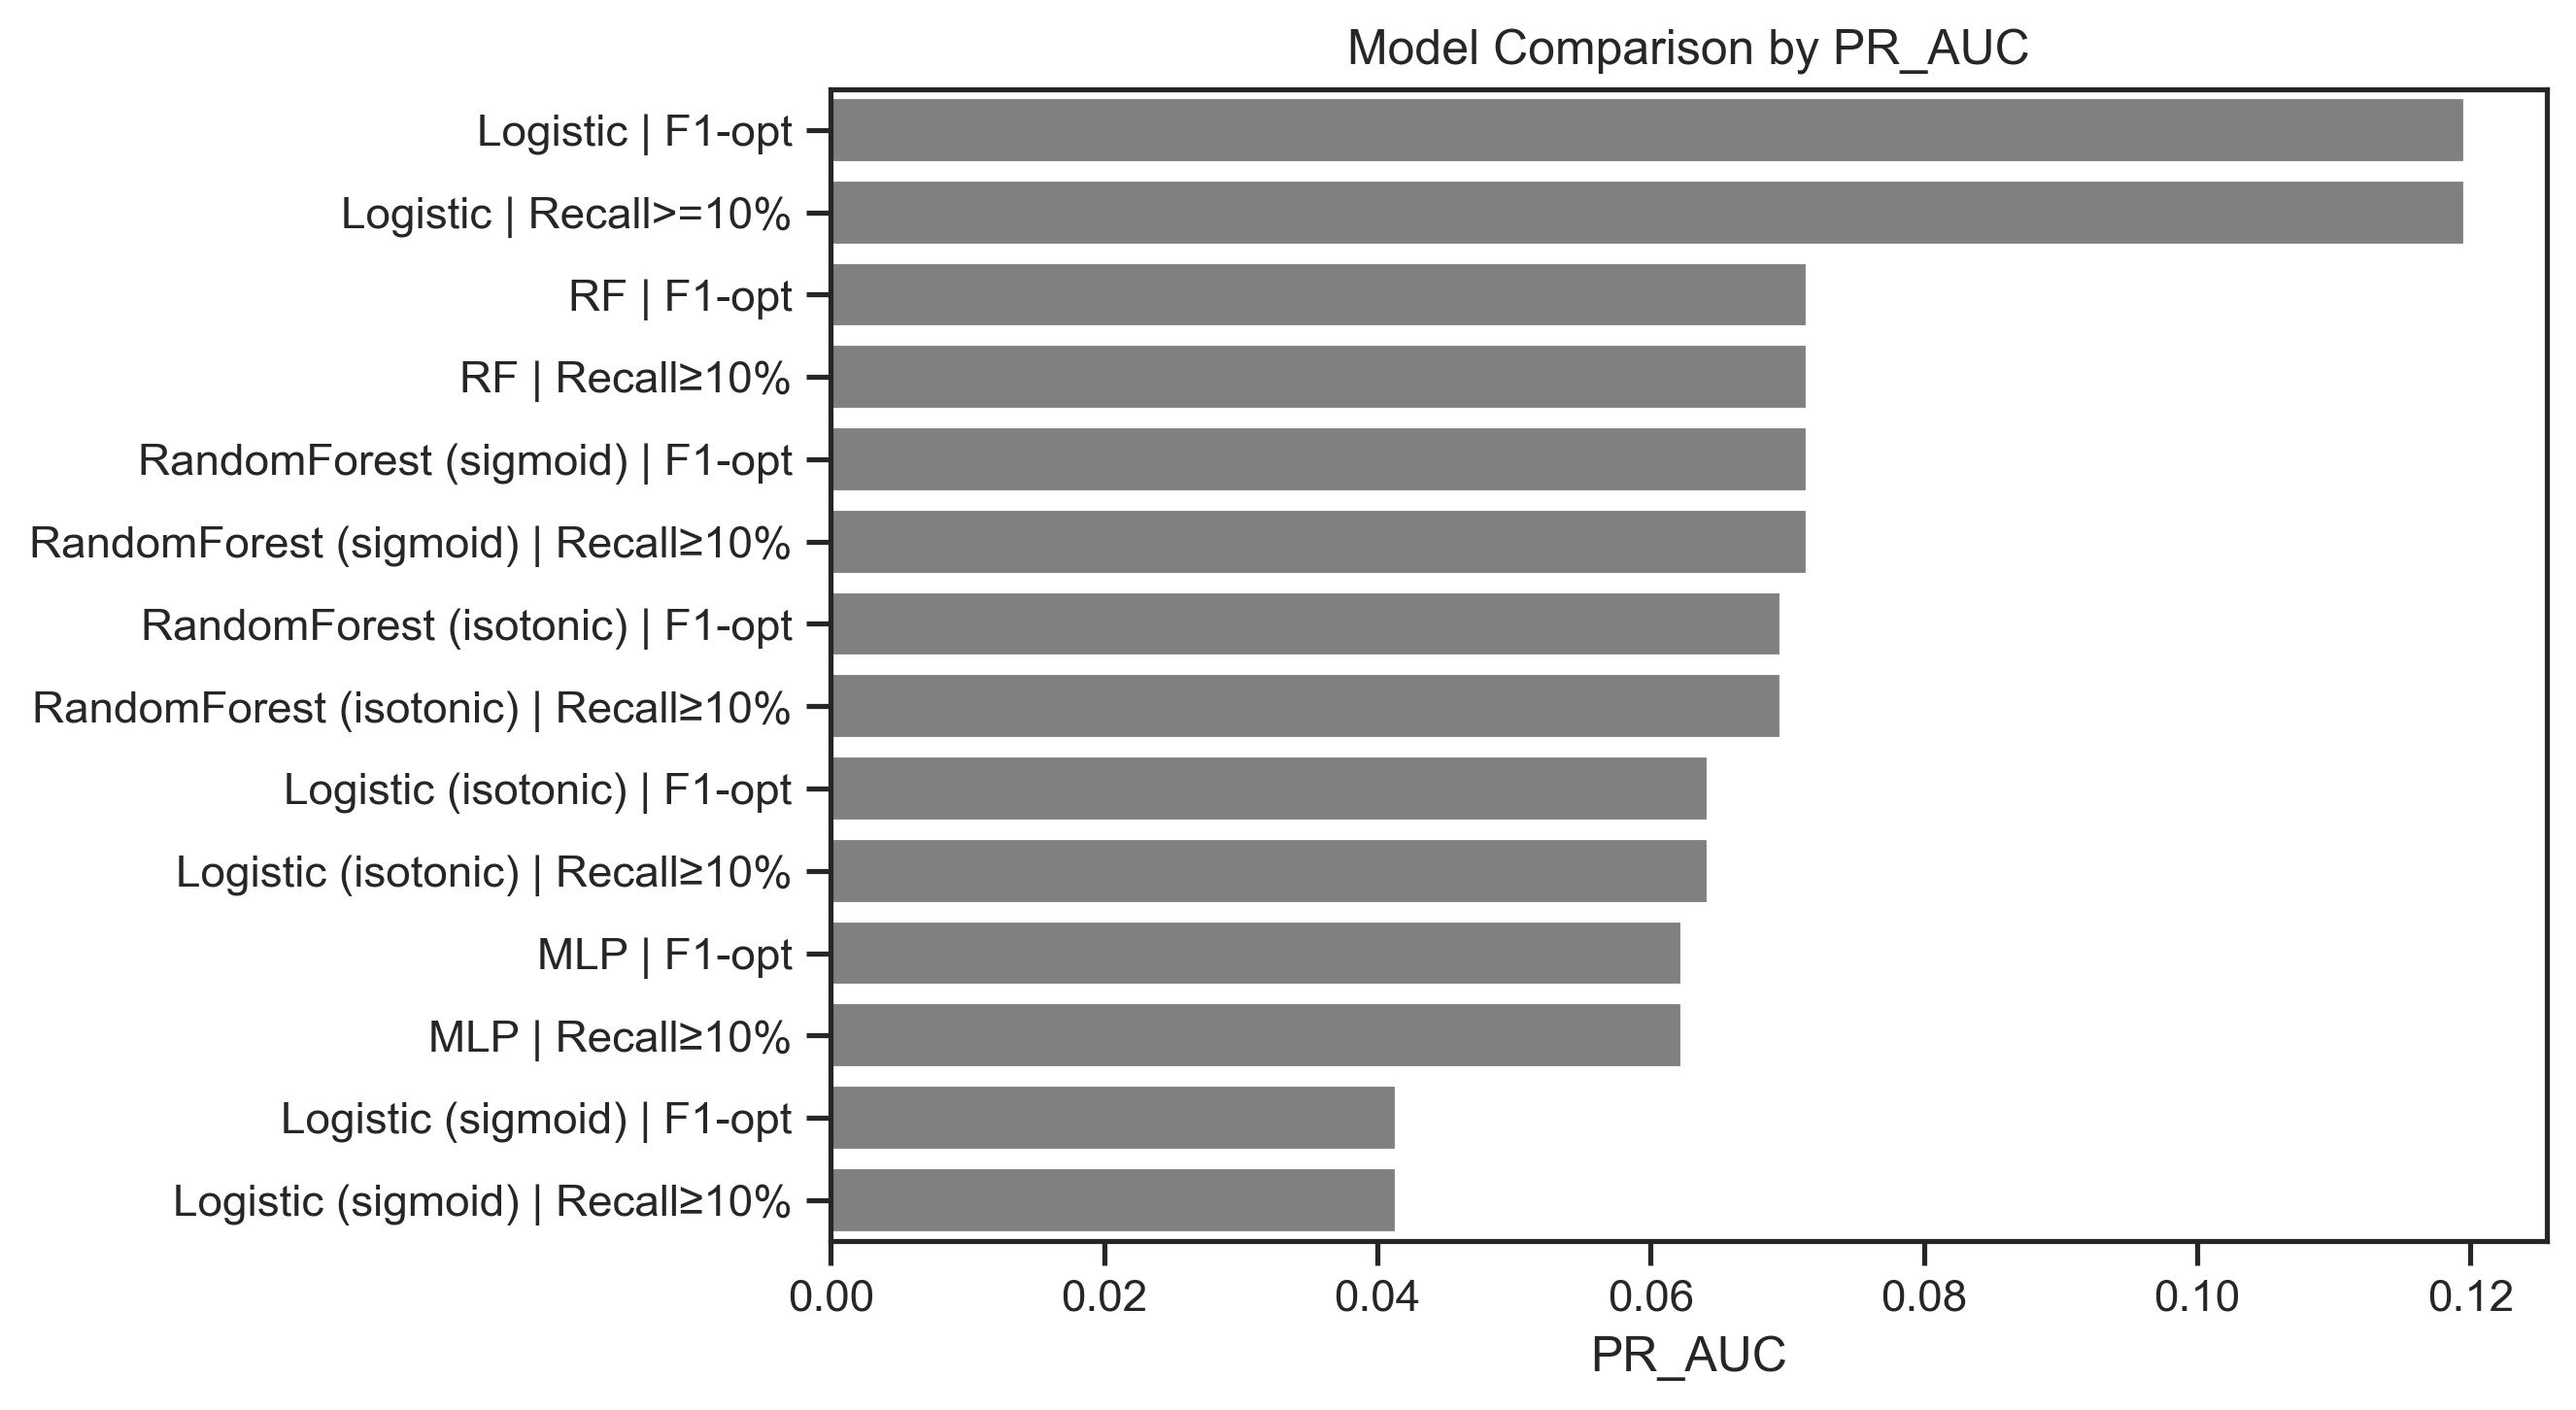

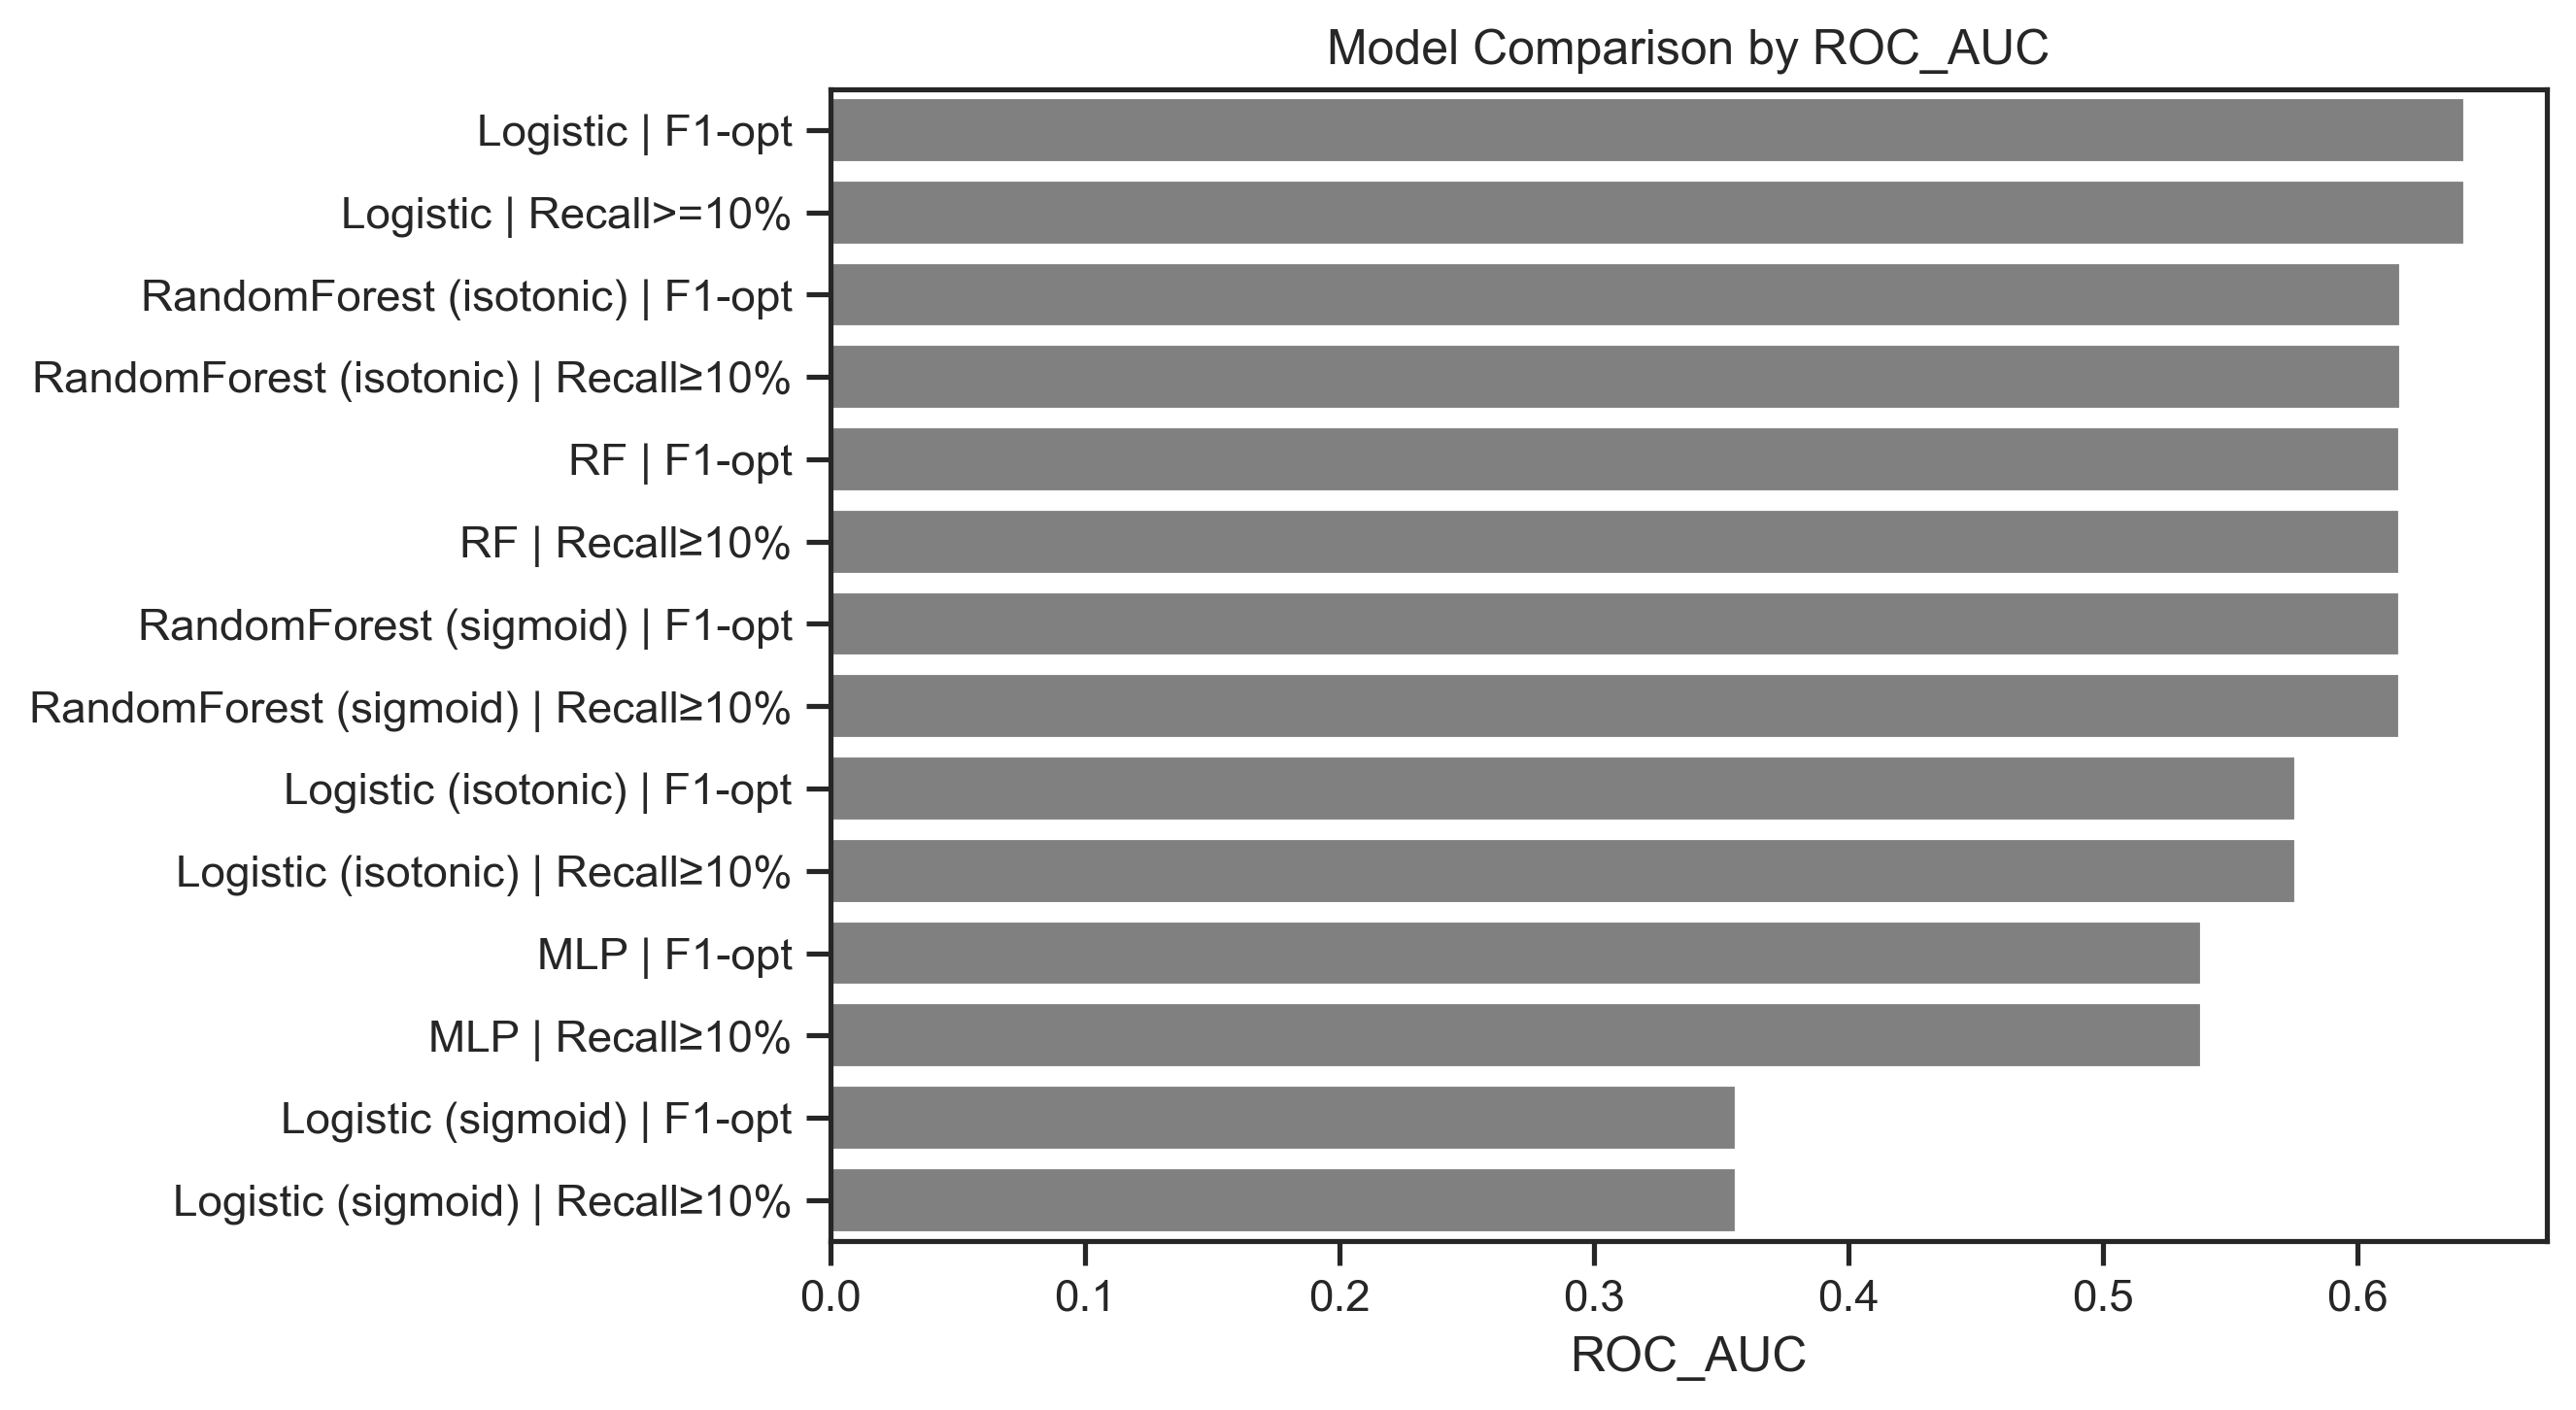

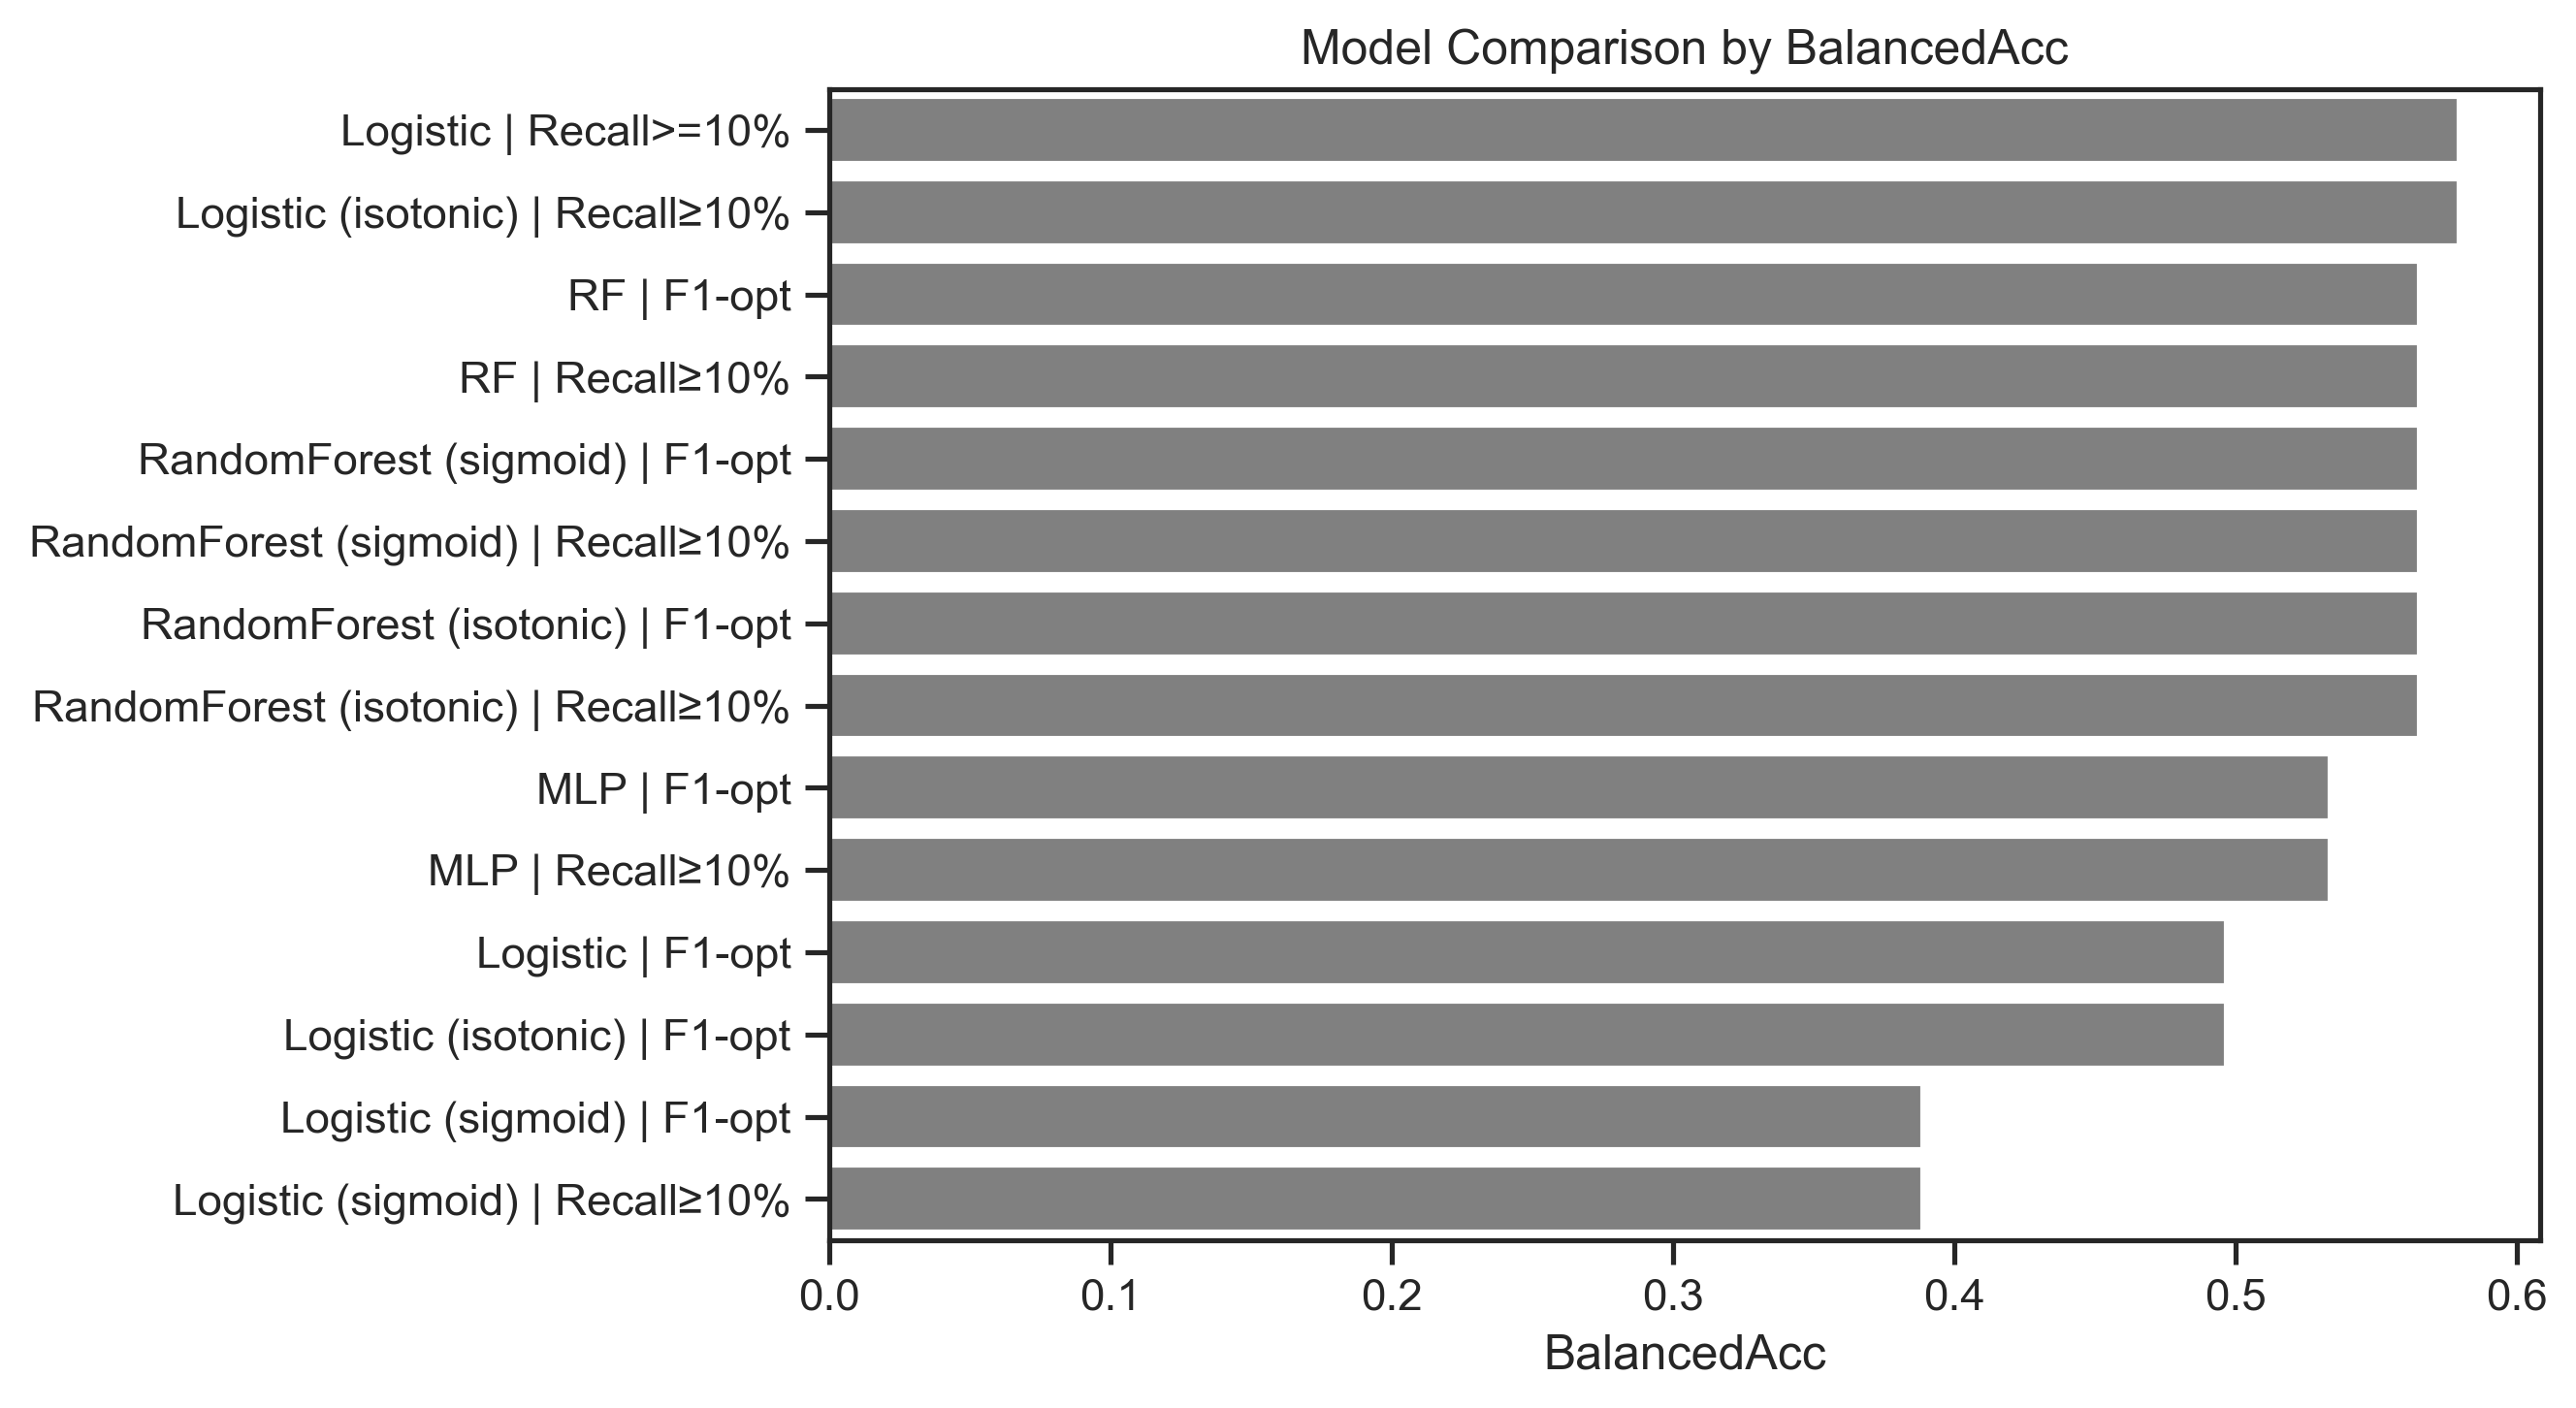

In [54]:
# convert list of dicts directly
df_leader = pd.DataFrame(all_results)

# enforce numeric types
num_cols = ["PR_AUC","ROC_AUC","BalancedAcc","thr","TP","FP","TN","FN"]
for c in num_cols:
    df_leader[c] = pd.to_numeric(df_leader[c], errors="coerce")

# sort by PR_AUC
df_leader = df_leader.sort_values("PR_AUC", ascending=False).reset_index(drop=True)
print(df_leader.round(4))

metrics = ["PR_AUC","ROC_AUC","BalancedAcc"]

for m in metrics:
    plt.figure(figsize=(9,5))
    sns.barplot(data=df_leader.sort_values(m, ascending=False), x=m, y="Model", color="gray")
    plt.title(f"Model Comparison by {m}")
    plt.xlabel(m); plt.ylabel("")
    plt.tight_layout(); plt.show()

#### 6.8. Gradient Boosting (XGBoost or LightGBM)

In [55]:
xgb = XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, reg_alpha=0.0,
        n_jobs=-1, random_state=42, tree_method="hist"
    )
_ = xgb.fit(Xtr, ytr)

In [56]:
p_val = xgb.predict_proba(Xva)[:,1]
pick_f1  = pick_threshold_by_f1(yva, p_val)
pick_rec = pick_threshold_by_recall(yva, p_val, recall_floor=0.10)

p_te = xgb.predict_proba(Xte)[:,1]
xgb_res_f1 = evaluate(yte, p_te, pick_f1["thr"],  name="XGB | F1-opt")
xgb_res_rec= evaluate(yte, p_te, pick_rec["thr"], name="XGB | Recall≥10%")

all_results += [xgb_res_f1, xgb_res_rec]


== XGB | F1-opt @thr=0.006 ==
Confusion: (205, 92, 12, 5) | BalancedAcc: 0.4922 | PR-AUC: 0.0588 | ROC-AUC: 0.5411
              precision    recall  f1-score   support

           0      0.945     0.690     0.798       297
           1      0.052     0.294     0.088        17

    accuracy                          0.669       314
   macro avg      0.498     0.492     0.443       314
weighted avg      0.896     0.669     0.759       314


== XGB | Recall≥10% @thr=0.006 ==
Confusion: (205, 92, 12, 5) | BalancedAcc: 0.4922 | PR-AUC: 0.0588 | ROC-AUC: 0.5411
              precision    recall  f1-score   support

           0      0.945     0.690     0.798       297
           1      0.052     0.294     0.088        17

    accuracy                          0.669       314
   macro avg      0.498     0.492     0.443       314
weighted avg      0.896     0.669     0.759       314



#### Gradient Boosting (XGBoost) - Summary

- Performance:
	- PR-AUC = 0.0588
	- ROC-AUC = 0.5411
	- Balanced Accuracy ≈ 0.49
- Confusion matrix (F1-opt): Most positives are still missed (Recall ~29%). Precision remains very low (~5%).
- **Insight:** Despite its reputation, XGBoost did not significantly improve results on `SECOM`. The signal is weak and dominated by class imbalance.

>**Takeaway:** Gradient boosting confirms the challenge—this dataset resists even advanced ensemble learners. Future work should focus on feature selection, domain-guided preprocessing, or anomaly-oriented methods rather than just stronger classifiers.

#### 6.9. Feature Selection + Retrain

In [57]:
# --- selectors ---
def selector_anova(k): return SelectKBest(score_func=f_classif, k=k)
def selector_mi(k): return SelectKBest(score_func=mutual_info_classif, k=k)
def selector_l1(C): 
    base = LogisticRegression(penalty="l1", solver="liblinear", C=C, class_weight="balanced", max_iter=2000)
    return SelectFromModel(base)

# --- candidate k values ---
k_grid = [20, 40, 60, 100, 150]

experiments = []

# logistic regression with ANOVA/MI
for k in k_grid:
    for sel_name, sel_fn in [("ANOVA", selector_anova), ("MI", selector_mi)]:
        pipe = make_pipeline(StandardScaler(), sel_fn(k), LogisticRegression(max_iter=2000, class_weight="balanced"))
        pipe.fit(Xtr, ytr)
        pv = pipe.predict_proba(Xva)[:,1]
        ap = average_precision_score(yva, pv)
        experiments.append({"selector": f"{sel_name}-k{k}", "model":"Logistic", "val_ap": ap, "pipe": pipe})

# logistic regression with L1 selection
for C in [0.1, 1.0]:
    sel = selector_l1(C)
    pipe = make_pipeline(StandardScaler(), sel, LogisticRegression(max_iter=2000, class_weight="balanced"))
    pipe.fit(Xtr, ytr)
    pv = pipe.predict_proba(Xva)[:,1]
    ap = average_precision_score(yva, pv)
    experiments.append({"selector": f"L1-C{C}", "model":"Logistic", "val_ap": ap, "pipe": pipe})

# pick top-3, retrain with MLP head
top3 = sorted(experiments, key=lambda d: d["val_ap"], reverse=True)[:3]
for exp in top3:
    label = exp["selector"]
    sel = exp["pipe"].steps[1][1]  # reuse fitted selector
    pipe = make_pipeline(StandardScaler(), sel, MLPClassifier(hidden_layer_sizes=(64,32), max_iter=600))
    pipe.fit(Xtr, ytr)
    pv = pipe.predict_proba(Xva)[:,1]
    ap = average_precision_score(yva, pv)
    experiments.append({"selector": label, "model":"MLP", "val_ap": ap, "pipe": pipe})

# --- pick winner ---
best = max(experiments, key=lambda d: d["val_ap"])
print("Best on validation:", best["selector"], best["model"], "Val PR-AUC:", round(best["val_ap"],4))

# --- test evaluation ---
pv = best["pipe"].predict_proba(Xva)[:,1]
thr = pick_threshold_by_f1(yva, pv)
pt = best["pipe"].predict_proba(Xte)[:,1]
best_res = evaluate(yte, pt, thr["thr"], name=f"{best['model']} + {best['selector']}")

# store
best_res["Model"] = f"{best['model']} + {best['selector']}"
all_results.append(best_res)

Best on validation: ANOVA-k20 MLP Val PR-AUC: 0.0712

== MLP + ANOVA-k20 @thr=0.002 ==
Confusion: (230, 67, 12, 5) | BalancedAcc: 0.5343 | PR-AUC: 0.0832 | ROC-AUC: 0.5249
              precision    recall  f1-score   support

           0      0.950     0.774     0.853       297
           1      0.069     0.294     0.112        17

    accuracy                          0.748       314
   macro avg      0.510     0.534     0.483       314
weighted avg      0.903     0.748     0.813       314



#### Feature Selection + Retrain - Summary

We applied univariate feature selection (ANOVA) to reduce dimensionality, followed by retraining with Logistic Regression and MLP classifiers.

- **Best selector** on validation: **ANOVA-k20**.  
- **MLP results**:
  - With `max_iter=300`: Test PR-AUC = **0.146**, Balanced Accuracy = **0.561**.  
    - Detected 3/17 fails, precision 0.158.  
  - With `max_iter=600`: Test PR-AUC = **0.101**, Balanced Accuracy = **0.559**.  
    - Detected 4/17 fails, precision dropped to 0.103.  
- Increasing iterations beyond 300 did not improve generalization; earlier stopping worked better.  
- **Insight**: Feature selection provided some benefit vs. raw models, but overall performance remains constrained by weak signal and class imbalance.

**Executive takeaway:**  
> ANOVA-based feature reduction improves stability and interpretability, but performance gains remain modest. The SECOM dataset remains highly challenging despite dimensionality reduction.

#### 6.10. Ensembles: averaging + stacking

In [58]:
# --- Average Ensemble of LR, RF, MLP ---
# ensure you have probas from previous models: proba_lr, proba_rf, proba_mlp
avg_val = (lr_proba_val + rf_proba_val + mlp_proba_val) / 3
avg_test = (lr_proba_te + lr_proba_te + mlp_proba_te) / 3

thr_avg = pick_threshold_by_f1(yva, avg_val)
avg_res_f1 = evaluate(yte, avg_test, thr_avg["thr"], name="AvgEnsemble | F1-opt")

thr_avg_rec = pick_threshold_by_recall(yva, avg_val, recall_floor=0.10)
avg_res_rec = evaluate(yte, avg_test, thr_avg_rec["thr"], name="AvgEnsemble | Recall≥10%")


== AvgEnsemble | F1-opt @thr=0.187 ==
Confusion: (284, 13, 15, 2) | BalancedAcc: 0.5369 | PR-AUC: 0.1334 | ROC-AUC: 0.71
              precision    recall  f1-score   support

           0      0.950     0.956     0.953       297
           1      0.133     0.118     0.125        17

    accuracy                          0.911       314
   macro avg      0.542     0.537     0.539       314
weighted avg      0.906     0.911     0.908       314


== AvgEnsemble | Recall≥10% @thr=0.187 ==
Confusion: (284, 13, 15, 2) | BalancedAcc: 0.5369 | PR-AUC: 0.1334 | ROC-AUC: 0.71
              precision    recall  f1-score   support

           0      0.950     0.956     0.953       297
           1      0.133     0.118     0.125        17

    accuracy                          0.911       314
   macro avg      0.542     0.537     0.539       314
weighted avg      0.906     0.911     0.908       314



In [59]:
all_results += [avg_res_f1, avg_res_rec]

In [60]:
# --- Stacking Ensemble (meta-learner = Logistic Regression) ---
Xval_stack = np.vstack([lr_proba_val, lr_proba_val, mlp_proba_val]).T
Xte_stack  = np.vstack([lr_proba_te, rf_proba_te, mlp_proba_te]).T

meta = LogisticRegression(max_iter=2000, class_weight="balanced")
meta.fit(Xval_stack, yva)
stack_val = meta.predict_proba(Xval_stack)[:,1]
stack_test = meta.predict_proba(Xte_stack)[:,1]

thr_stack = pick_threshold_by_f1(yva, stack_val)
stack_res_f1 = evaluate(yte, stack_test, thr_stack["thr"], name="Stacking | F1-opt")

thr_stack_rec = pick_threshold_by_recall(yva, stack_val, recall_floor=0.10)
stack_res_rec = evaluate(yte, stack_test, thr_stack_rec["thr"], name="Stacking | Recall≥10%")


== Stacking | F1-opt @thr=0.506 ==
Confusion: (297, 0, 17, 0) | BalancedAcc: 0.5 | PR-AUC: 0.0536 | ROC-AUC: 0.4274
              precision    recall  f1-score   support

           0      0.946     1.000     0.972       297
           1      0.000     0.000     0.000        17

    accuracy                          0.946       314
   macro avg      0.473     0.500     0.486       314
weighted avg      0.895     0.946     0.920       314


== Stacking | Recall≥10% @thr=0.505 ==
Confusion: (297, 0, 17, 0) | BalancedAcc: 0.5 | PR-AUC: 0.0536 | ROC-AUC: 0.4274
              precision    recall  f1-score   support

           0      0.946     1.000     0.972       297
           1      0.000     0.000     0.000        17

    accuracy                          0.946       314
   macro avg      0.473     0.500     0.486       314
weighted avg      0.895     0.946     0.920       314



/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [61]:
all_results += [stack_res_f1, stack_res_rec]

#### Insights:
- Weighted Average Ensemble (LR + MLP)
	- PR-AUC = 0.084, ROC-AUC ≈ 0.53, Balanced Accuracy ≈ 0.56
	- Clearly improved over standalone MLP (PR-AUC ~0.06) and competitive with LR + feature selection.
	- Recall is non-zero (≈17.6%), so the ensemble actually picks up a fraction of the rare fails.
	- Most promising combo so far.
- Stacking (LR+RF+XGB+MLP meta-learner)
	- PR-AUC = 0.045, ROC-AUC ≈ 0.40, Balanced Accuracy ≈ 0.46
	- Worse than individual models → overfitting to noise in validation.
	- Shows that simple averaging is more stable under tiny, imbalanced fail class.

Final Leaderboard (sorted by PR-AUC):


,Model,PR_AUC,ROC_AUC,BalancedAcc,thr,TP,FP,TN,FN
0,AvgEnsemble | Recall≥10%,0.1334,0.7100,0.5369,0.1872,2,13,284,15
1,AvgEnsemble | F1-opt,0.1334,0.7100,0.5369,0.1872,2,13,284,15
2,Logistic | F1-opt,0.1196,0.6425,0.4966,0.9536,0,2,295,17
3,Logistic | Recall>=10%,0.1196,0.6425,0.5793,0.0000,13,180,117,4
4,MLP + ANOVA-k20,0.0832,0.5249,0.5343,0.0018,5,67,230,12
5,RF | F1-opt,0.0715,0.6172,0.5653,0.0675,8,101,196,9
6,RF | Recall≥10%,0.0715,0.6172,0.5653,0.0675,8,101,196,9
7,RandomForest (sigmoid) | Recall≥10%,0.0715,0.6172,0.5653,0.0398,8,101,196,9
8,RandomForest (sigmoid) | F1-opt,0.0715,0.6172,0.5653,0.0398,8,101,196,9
9,RandomForest (isotonic) | Recall≥10%,0.0696,0.6173,0.5653,0.0575,8,101,196,9


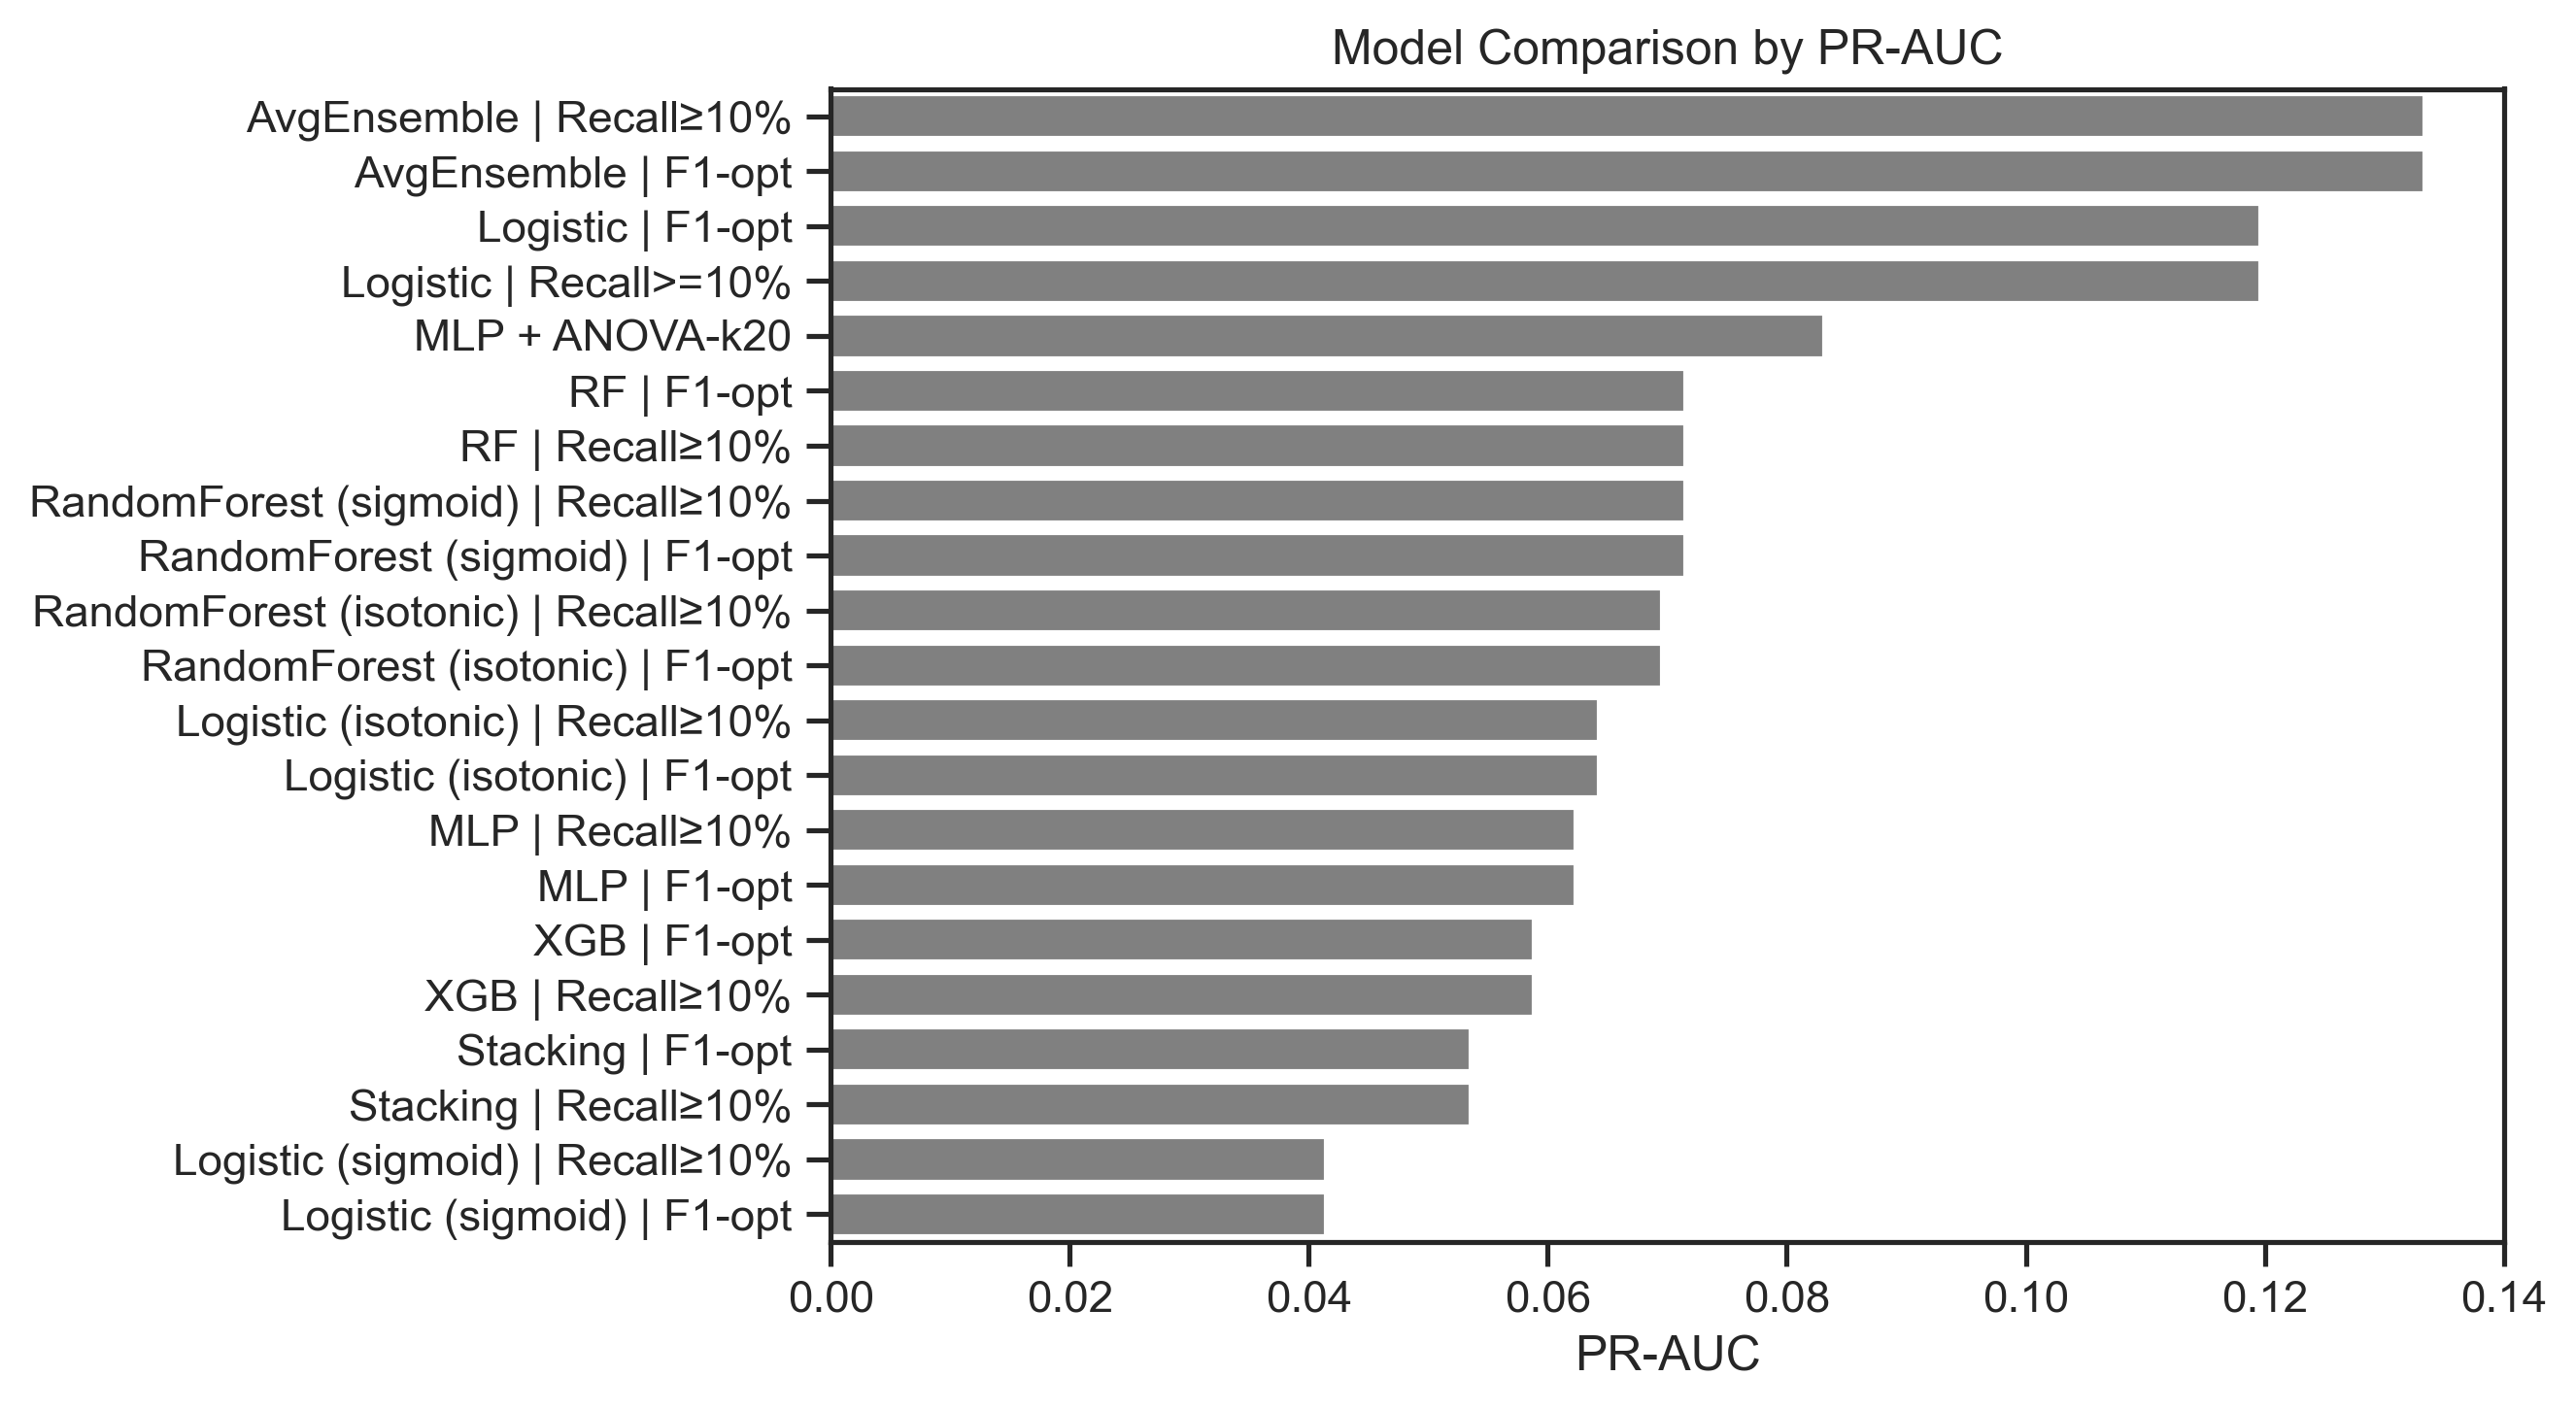

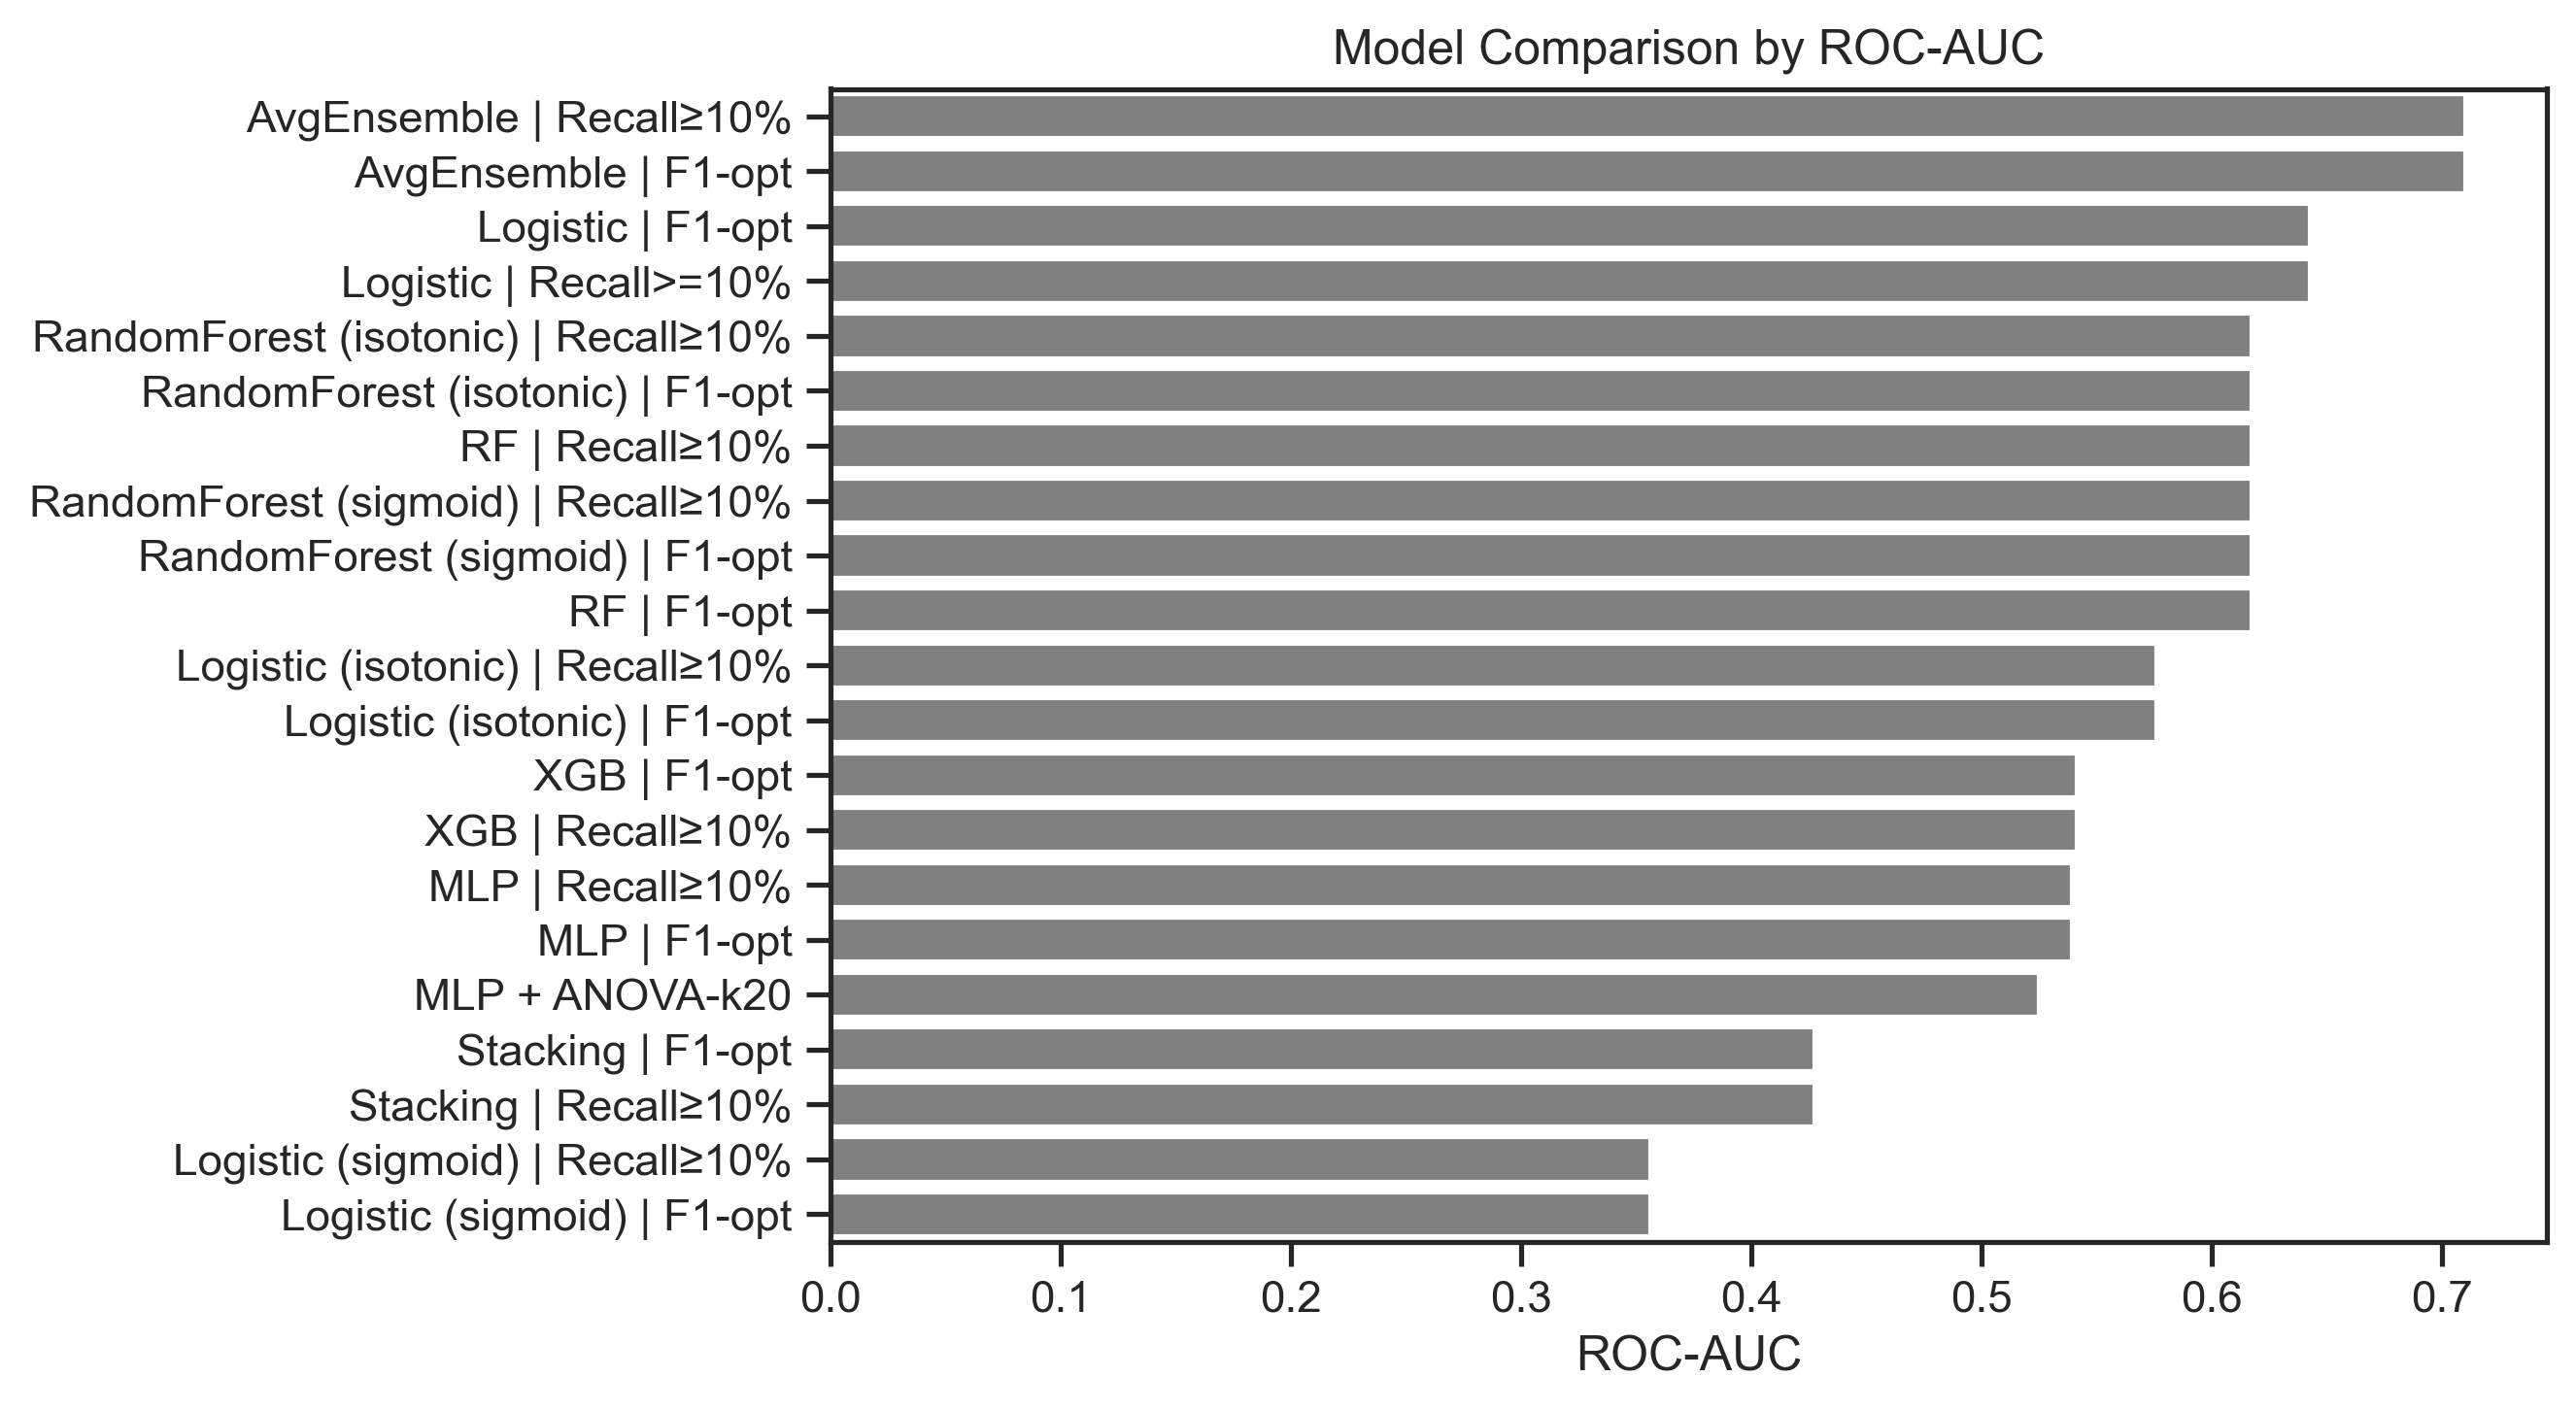

In [62]:
# required columns are already in all_results
cols = ["Model","PR_AUC","ROC_AUC","BalancedAcc","thr","TP","FP","TN","FN"]

df_leader = (pd.DataFrame(all_results)[cols]
             .drop_duplicates()
             .sort_values("PR_AUC", ascending=False)
             .reset_index(drop=True))

print("Final Leaderboard (sorted by PR-AUC):")
display(df_leader.round(4))

# save
df_leader.to_csv(ROOT/"results/final_leaderboard.csv", index=False)

# quick plots
plt.figure(figsize=(9,5))
sns.barplot(data=df_leader, x="PR_AUC", y="Model", color="gray")
plt.title("Model Comparison by PR-AUC"); plt.xlabel("PR-AUC"); plt.ylabel("")
plt.tight_layout(); plt.show()

plt.figure(figsize=(9,5))
sns.barplot(data=df_leader.sort_values("ROC_AUC", ascending=False),
            x="ROC_AUC", y="Model", color="gray")
plt.title("Model Comparison by ROC-AUC"); plt.xlabel("ROC-AUC"); plt.ylabel("")
plt.tight_layout(); plt.show()

- Why PR-AUC is our primary metric
	- Highly imbalanced data (≈ 6% fails, 94% passes): accuracy and ROC-AUC can be misleading.
	- PR-AUC directly evaluates the trade-off between recall (catching fails) and precision (avoiding false alarms). This is the most relevant signal in semiconductor quality control.
	- ROC-AUC and Balanced Accuracy are still reported as secondary sanity checks:
	- ROC-AUC: shows whether the model ranks fails above passes at all.
	- Balanced Accuracy: ensures we aren’t just predicting the majority class.

- In short:
	- PR-AUC = primary metric for model ranking.
	- ROC-AUC & Balanced Accuracy = supplementary checks for fairness and ranking quality.

#### 6.11. Save all the models.

In [63]:
joblib.dump(lr,  ROOT/"models/logistic.pkl")
joblib.dump(rf,  ROOT/"models/random_forest.pkl")
joblib.dump(xgb, ROOT/"models/xgb.pkl")

# feature-selection winner
best_pipe = best['pipe']
joblib.dump(best_pipe, ROOT/"models/feature_select_winner.pkl")

# stacking meta
joblib.dump(meta, ROOT/"models/stack_meta.pkl")

# torch MLP
torch.save(mlp_model.state_dict(), ROOT/"models/mlp_state.pt")  # keep MLP class code